# Setup

In [1]:
import os 
os.chdir('/home/imendoza/bliss')

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
%matplotlib inline

In [61]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.reporting import add_extra_coadd_info, scene_metrics, plot_image, get_params_from_coadd
from bliss.predict import predict_on_scene

from astropy.table import Table

In [5]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [6]:
# check GPU is configured correctly
!export CUDA_VISIBLE_DEVICES="1"
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

1


# Load data

In [7]:
bp = 24
clen = 300
pixel_scale=0.396
run = 94
camcol = 1
field = 12
bands = (2,)
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=run,
    camcol=camcol,
    fields=(field,),
    bands=bands,
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

wcs = sdss_data[0]['wcs'][0]
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
scene = sdss_data[0]["image"][0]
h,w = scene.shape[-2], scene.shape[-1]
print(h, w)

1489 2048


In [8]:
# load coadd catalog
coadd_catalog_file = 'data/coadd_catalog_94_1_12.fits'
psf_image_file = 'data/psField-000094-1-0012-PSF-image.npy'
add_extra_coadd_info(coadd_catalog_file, psf_image_file, pixel_scale, wcs)

In [9]:
coadd_cat = Table.read(coadd_catalog_file, format='fits')
coadd_params = get_params_from_coadd(coadd_cat, h, w, bp)

# Load models

In [11]:
from bliss.models.binary import BinaryEncoder
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.sleep import SleepPhase

In [12]:
# prepare BLISS model 
sleep_file = '/home/imendoza/bliss/models/sdss_sleep.ckpt'
galaxy_encoder_file = '/home/imendoza/bliss/models/sdss_galaxy_encoder.ckpt'
binary_file = '/home/imendoza/bliss/models/sdss_binary.ckpt'


# load models
sleep_net = SleepPhase.load_from_checkpoint(sleep_file).to('cpu')
image_encoder= sleep_net.image_encoder.to(device).eval()
binary_encoder = BinaryEncoder.load_from_checkpoint(binary_file).to(device).eval()
galaxy_encoder = GalaxyEncoder.load_from_checkpoint(galaxy_encoder_file).to(device).eval()
galaxy_decoder = sleep_net.image_decoder.galaxy_tile_decoder.galaxy_decoder.eval().to(device)

# Prediction

In [13]:
torch.cuda.empty_cache()

In [14]:
# predict using models 

clen = 300
_scene = torch.from_numpy(scene).reshape(1, 1, h, w)
_, est_params = predict_on_scene(clen, _scene, image_encoder, binary_encoder, 
                                 galaxy_encoder, galaxy_decoder, device) 

7 5


  0%|                                                                                                                                                                                                | 0/35 [00:00<?, ?it/s]

0 0 24 24
torch.Size([1, 1, 348, 348])
300 300 5625


  3%|█████▎                                                                                                                                                                                  | 1/35 [00:01<00:49,  1.46s/it]

0 1 24 324
torch.Size([1, 1, 348, 348])
300 300 5625


  6%|██████████▌                                                                                                                                                                             | 2/35 [00:02<00:48,  1.46s/it]

0 2 24 624
torch.Size([1, 1, 348, 348])
300 300 5625


  9%|███████████████▊                                                                                                                                                                        | 3/35 [00:04<00:46,  1.46s/it]

0 3 24 924
torch.Size([1, 1, 348, 348])
300 300 5625


 11%|█████████████████████                                                                                                                                                                   | 4/35 [00:05<00:45,  1.46s/it]

0 4 24 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 14%|██████████████████████████▎                                                                                                                                                             | 5/35 [00:07<00:40,  1.36s/it]

1 0 324 24
torch.Size([1, 1, 348, 348])
300 300 5625


 17%|███████████████████████████████▌                                                                                                                                                        | 6/35 [00:08<00:40,  1.39s/it]

1 1 324 324
torch.Size([1, 1, 348, 348])
300 300 5625


 20%|████████████████████████████████████▊                                                                                                                                                   | 7/35 [00:09<00:39,  1.41s/it]

1 2 324 624
torch.Size([1, 1, 348, 348])
300 300 5625


 23%|██████████████████████████████████████████                                                                                                                                              | 8/35 [00:11<00:38,  1.43s/it]

1 3 324 924
torch.Size([1, 1, 348, 348])
300 300 5625


 26%|███████████████████████████████████████████████▎                                                                                                                                        | 9/35 [00:12<00:37,  1.44s/it]

1 4 324 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 29%|████████████████████████████████████████████████████▎                                                                                                                                  | 10/35 [00:14<00:33,  1.36s/it]

2 0 624 24
torch.Size([1, 1, 348, 348])
300 300 5625


 31%|█████████████████████████████████████████████████████████▌                                                                                                                             | 11/35 [00:15<00:33,  1.39s/it]

2 1 624 324
torch.Size([1, 1, 348, 348])
300 300 5625


 34%|██████████████████████████████████████████████████████████████▋                                                                                                                        | 12/35 [00:16<00:32,  1.41s/it]

2 2 624 624
torch.Size([1, 1, 348, 348])
300 300 5625


 37%|███████████████████████████████████████████████████████████████████▉                                                                                                                   | 13/35 [00:18<00:31,  1.42s/it]

2 3 624 924
torch.Size([1, 1, 348, 348])
300 300 5625


 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 14/35 [00:19<00:30,  1.44s/it]

2 4 624 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 43%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 15/35 [00:21<00:27,  1.36s/it]

3 0 924 24
torch.Size([1, 1, 348, 348])
300 300 5625


 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 16/35 [00:22<00:26,  1.39s/it]

3 1 924 324
torch.Size([1, 1, 348, 348])
300 300 5625


 49%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 17/35 [00:23<00:25,  1.41s/it]

3 2 924 624
torch.Size([1, 1, 348, 348])
300 300 5625


 51%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 18/35 [00:25<00:24,  1.43s/it]

3 3 924 924
torch.Size([1, 1, 348, 348])
300 300 5625


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 19/35 [00:26<00:22,  1.44s/it]

3 4 924 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 20/35 [00:28<00:20,  1.36s/it]

4 0 1224 24
torch.Size([1, 1, 348, 348])
300 300 5625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 21/35 [00:29<00:19,  1.39s/it]

4 1 1224 324
torch.Size([1, 1, 348, 348])
300 300 5625


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 22/35 [00:31<00:18,  1.41s/it]

4 2 1224 624
torch.Size([1, 1, 348, 348])
300 300 5625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 23/35 [00:32<00:17,  1.43s/it]

4 3 1224 924
torch.Size([1, 1, 348, 348])
300 300 5625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 24/35 [00:33<00:15,  1.45s/it]

4 4 1224 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 25/35 [00:35<00:13,  1.37s/it]

5 0 1524 24
torch.Size([1, 1, 348, 348])
300 300 5625


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 26/35 [00:36<00:12,  1.40s/it]

5 1 1524 324
torch.Size([1, 1, 348, 348])
300 300 5625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 27/35 [00:38<00:11,  1.42s/it]

5 2 1524 624
torch.Size([1, 1, 348, 348])
300 300 5625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 28/35 [00:39<00:10,  1.43s/it]

5 3 1524 924
torch.Size([1, 1, 348, 348])
300 300 5625


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 29/35 [00:41<00:08,  1.44s/it]

5 4 1524 1225
torch.Size([1, 1, 288, 348])
240 300 4500


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 30/35 [00:42<00:06,  1.37s/it]

6 0 1824 24
torch.Size([1, 1, 348, 248])
300 200 3750


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 31/35 [00:43<00:05,  1.26s/it]

6 1 1824 324
torch.Size([1, 1, 348, 248])
300 200 3750


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 32/35 [00:44<00:03,  1.18s/it]

6 2 1824 624
torch.Size([1, 1, 348, 248])
300 200 3750


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 33/35 [00:45<00:02,  1.12s/it]

6 3 1824 924
torch.Size([1, 1, 348, 248])
300 200 3750


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 34/35 [00:46<00:01,  1.09s/it]

6 4 1824 1225
torch.Size([1, 1, 288, 248])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:47<00:00,  1.34s/it]

240 200 3000


## Check locations are sensible using plotly

In [25]:
# import plotly.express as px
# import plotly.graph_objects as go

# fig = px.imshow(scene, zmin=800, zmax=900)
# fig.update_layout(width=800, height=800)
# plocs = est_params['plocs'].cpu().numpy()
# scatter_true = go.Scatter(name='coadd', x=coadd_params['x'], y=coadd_params['y'], mode='markers', marker=dict(color='blue', size=8, symbol='x'))
# scatter_est = go.Scatter(name='estimate', x=plocs[:, 0], y=plocs[:, 1], mode='markers', marker=dict(color='red', size=9, symbol='circle'))

# fig.add_trace(scatter_true)
# fig.add_trace(scatter_est)
# fig.show()

# Results

In [83]:
# max mag in est_params ~ 22.5
print(h, w, bp)
# extract 'true' parameters based on coadd catalog.
coadd_params = get_params_from_coadd(coadd_cat, h, w, bp)
scene_metrics(coadd_params, est_params, mag_cut=18, slack=1.0, mag_slack=0.5)

1489 2048 24


/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric ClassificationMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.



{'precision': tensor(0.8361),
 'recall': tensor(0.9000),
 'f1': tensor(0.8669),
 'class_acc': tensor(0.9333),
 'conf_matrix': tensor([[ 5,  3],
         [ 0, 37]])}

# Plot

## Collect for all magnitude bins

In [90]:
mag_bins = np.arange(18, 23, 0.1) #skip 23
precisions = [] 
recalls = []
class_accs = [] 
for mag in mag_bins: 
    res = scene_metrics(coadd_params, est_params, mag_cut=mag, slack=1.0, mag_slack=0.5)
    precisions.append(res['precision'].item())
    recalls.append(res['recall'].item())
    class_accs.append(res['class_acc'].item())

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric ClassificationMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric ClassificationMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric ClassificationMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric DetectionMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

The ``compute`` method of metric ClassificationMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/

## lineplot

In [111]:
import seaborn as sns
from plot_defaults import set_rc_params, format_plot, CB_color_cycle
sns.set_theme(style="darkgrid")
set_rc_params()

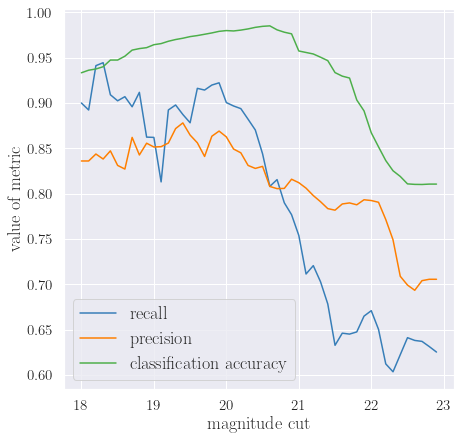

In [115]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
format_plot(ax, xlabel=r'\rm magnitude cut', ylabel=r'value of metric')
ax.plot(mag_bins, recalls, label=r'\rm recall')
ax.plot(mag_bins, precisions, label=r'\rm precision')
ax.plot(mag_bins, class_accs, label=r'\rm classification accuracy')
ax.legend()

In [100]:
sns.lineplot?

Text(0.5, 0, 'true mag.')

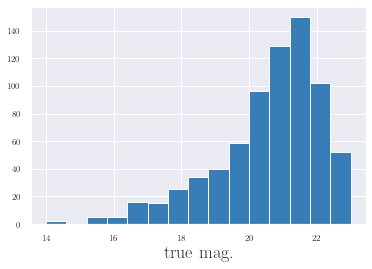

In [121]:
%matplotlib inline
plt.hist(coadd_params['mag'].numpy(), bins=15, range=(14, 23))
plt.xlabel('true mag.', size=18)

Text(0.5, 0, 'est mag.')

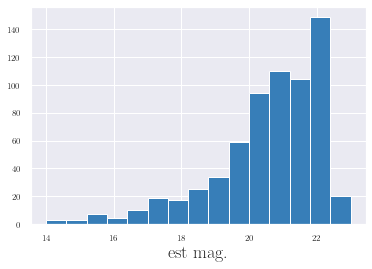

In [122]:
%matplotlib inline
plt.hist(est_params['mag'].numpy(), bins=15, range=(14, 23))
plt.xlabel('est mag.', size=18)